# Routine to calculate PDFs of quantities from CAM h0 or climo files
## Includes lowest level tendencies to demonstrate impact of ZM parcel calculation

In [14]:
def pdf_data_proc(case,fdir,vname,vscale,vtrange):
    
    ''' Routines to process input data for this case for plotting PDF '''
    
    print()
    print('CASE = ',case)
    
    
   
    ffile = fdir+case+'/atm/hist/'+case+'*h1*1979-01*nc'
    flist = sorted(glob.glob(ffile))
    fhist =  xr.open_mfdataset(flist)  
    fhist = fhist.sel(time=slice(vtrange[0], vtrange[1]))
    
    fvar = fhist[vname]
    vlong =  fvar.attrs['long_name']    
    fvar = vscale*fvar
    
    
    print(ffile)
    
    
# Is PRECC on same file as variable? If not read in different stream.

    two_streams = False if 'PRECC' in fhist.variables else True
    
    if two_streams :
        
        ffile = fdir+case+'/atm/hist/'+case+'*h3*1979-01*nc'
        flist = sorted(glob.glob(ffile))
        fhist =  xr.open_mfdataset(flist)  
        fhist = fhist.sel(time=slice(vtrange[0], vtrange[1]))
                   
    fprecc = 86400.*1000.*fhist['PRECC']
        
    print(ffile)
    


        
## Variable masking ##
## Lowest level of a 3D variable
    
    if (vname == 'PRECC'):
        fvar = fprecc
    else:
        fvar = fvar[:,-1,:,:]
        
# Mask
    fvar = fvar.where(fprecc > 1.)
    
# 1d-ize
    pvar_1d = fvar.values.ravel()
    
    return pvar_1d,vlong

In [10]:
import numpy as np
import matplotlib.pyplot as mp
import xarray as xr
import pandas as pd
import glob
import seaborn as sbn

from distributed import Client, LocalCluster
from ncar_jobqueue import NCARCluster


In [3]:
cluster = NCARCluster()
cluster.scale(10)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/rneale/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/rneale/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.48:36394,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/rneale/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [15]:
# Read files #
#cases = ['f.e21.FWscHIST.ne30_L32_cam6_3_019_plus_CESM2.2.001.hf',
#        'f.e21.FWscHIST.ne30_L48_BL10_cam6_3_019_plus_CESM2.2.001.hf']

cases = ['f.e21.FWscHIST.ne30_L32_cam6_3_019_plus_CESM2.2.001.hf',
         'f.e21.FWscHIST.ne30_L48_BL10_cam6_3_019_plus_CESM2.2.001.hf',
         'f.e21.FWscHIST.ne30_L48_BL10_cam6_3_019_plus_CESM2.2.001_zm2.hf',
         'f.c6_3_41.FWscHIST.ne30_L58.zm2_fix.002']
        
         
#         'f.e21.FWscHIST.ne30_L48_BL10_cam6_3_039.001.hf2']
         
         
#         'f.e21.FWscHIST.ne30_L48_BL10_cam6_3_035.tphysac_reorder_zm2_revert_parcelT.001.hf2']
         
#         'f.e21.FWscHIST.ne30_L48_BL10_cam6_3_035.tphysac_zm2_reorder.001.hf2']


#cnames = ['L32','L48','L58']
cnames = ['L32','L58','L58.zm2','L58.zm2.fix']


dir_in = ['c','c','c','s'] # s-scracth, c-campaign

trange = ["1979-01-01","1979-01-31"]

#cases = 

season0 = 'DJF'


vname = 'ZMDT' ; vscale = 86400. ; vunits = 'K/day' ; xlims = [-30,10]
#vname = 'ZMDQ' ; vscale = 86400. ; vunits = 'K/day' ; xlims = [-60,20]
#vname = 'T' ; vscale = 1. ; vunits = 'K' ; xlims = [280,310]
#vname = 'DCQ' ; vscale = 86400.*1000. ; vunits = 'g/kg/day'; xlims = [-60,20]
#vname = 'STEND_CLUBB' ; vscale = 86400./1004. ; vunits = 'K/day' ; xlims = [-20,60]
#vname = 'PRECC' ; vscale = 86400.*1000. ; vunits ='mm/day'  ; xlims = [1,100]

vnamec = 'ZMDT' ; vscalec = 86400. ; vunitsc = 'K/day'

fdir_c = '/glade/campaign/cgd/amp/amwg/runs/'
fdir_s = '/glade/scratch/hannay/archive/'





CASE =  f.e21.FWscHIST.ne30_L32_cam6_3_019_plus_CESM2.2.001.hf
/glade/campaign/cgd/amp/amwg/runs/f.e21.FWscHIST.ne30_L32_cam6_3_019_plus_CESM2.2.001.hf/atm/hist/f.e21.FWscHIST.ne30_L32_cam6_3_019_plus_CESM2.2.001.hf*h1*1979-01*nc
/glade/campaign/cgd/amp/amwg/runs/f.e21.FWscHIST.ne30_L32_cam6_3_019_plus_CESM2.2.001.hf/atm/hist/f.e21.FWscHIST.ne30_L32_cam6_3_019_plus_CESM2.2.001.hf*h1*1979-01*nc

CASE =  f.e21.FWscHIST.ne30_L48_BL10_cam6_3_019_plus_CESM2.2.001.hf
/glade/campaign/cgd/amp/amwg/runs/f.e21.FWscHIST.ne30_L48_BL10_cam6_3_019_plus_CESM2.2.001.hf/atm/hist/f.e21.FWscHIST.ne30_L48_BL10_cam6_3_019_plus_CESM2.2.001.hf*h1*1979-01*nc
/glade/campaign/cgd/amp/amwg/runs/f.e21.FWscHIST.ne30_L48_BL10_cam6_3_019_plus_CESM2.2.001.hf/atm/hist/f.e21.FWscHIST.ne30_L48_BL10_cam6_3_019_plus_CESM2.2.001.hf*h1*1979-01*nc

CASE =  f.e21.FWscHIST.ne30_L48_BL10_cam6_3_019_plus_CESM2.2.001_zm2.hf
/glade/campaign/cgd/amp/amwg/runs/f.e21.FWscHIST.ne30_L48_BL10_cam6_3_019_plus_CESM2.2.001_zm2.hf/atm/hist

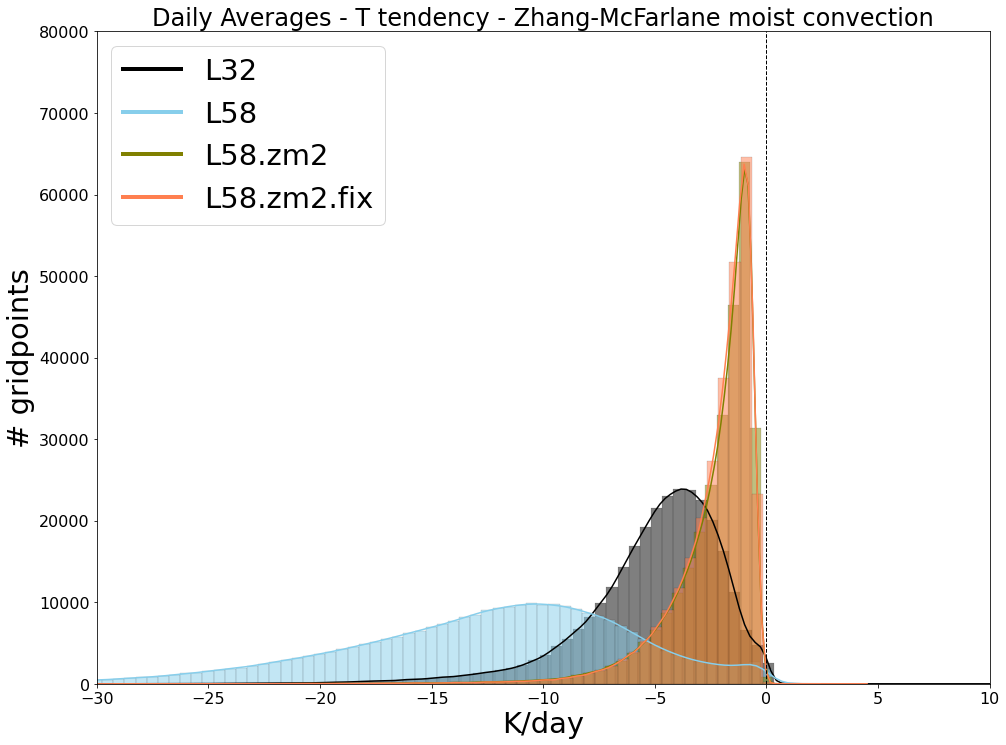

In [16]:
# PLOT HISTOGRAM #

plt1, ax1 = mp.subplots(1,1,figsize=(16, 12)) # Ave plot of all cases
#sbn.color_palette("colorblind")
colors = ['black','skyblue','olive','coral','purple']
#colors = ['black','blue','red','purple']

for ic,case in enumerate(cases):

    fdir0 = fdir_c if dir_in[ic] == 'c' else fdir_s
    
    fplot,vlong = pdf_data_proc(case,fdir0,vname,vscale,trange) # Main variable

    

#    ax1.hist(fplot,bins=200, alpha=0.6, label=cnames[ic])
    if vname=='PRECC':
        sbn.histplot(fplot, bins=100, color=colors[ic],linewidth=0.1,log_scale=True,multiple="stack",kde=True)
    else:
        sbn.histplot(fplot, binwidth=0.5, color=colors[ic],linewidth=0.1,multiple="stack",kde=True) 

leg = ax1.legend(cnames,loc='upper left',fontsize=29)

ylims = [0.,80000]

ax1.set_xlim(xlims)
ax1.set_ylim(ylims)

ax1.set_title('Daily Averages - '+vlong,fontsize=24)
ax1.set_ylabel('# gridpoints',fontsize=29) 
ax1.set_xlabel(vunits,fontsize=29)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.vlines(0.,ylims[0] ,ylims[1], color='black',linestyle="dashed",lw=1)

for line in leg.get_lines():
    line.set_linewidth(4.0)

plt1.savefig('pdf_vres_'+vname+'_Jul.png', dpi=100, bbox_inches='tight') 



TypeError: pdf_data_proc() missing 1 required positional argument: 'vtrange'

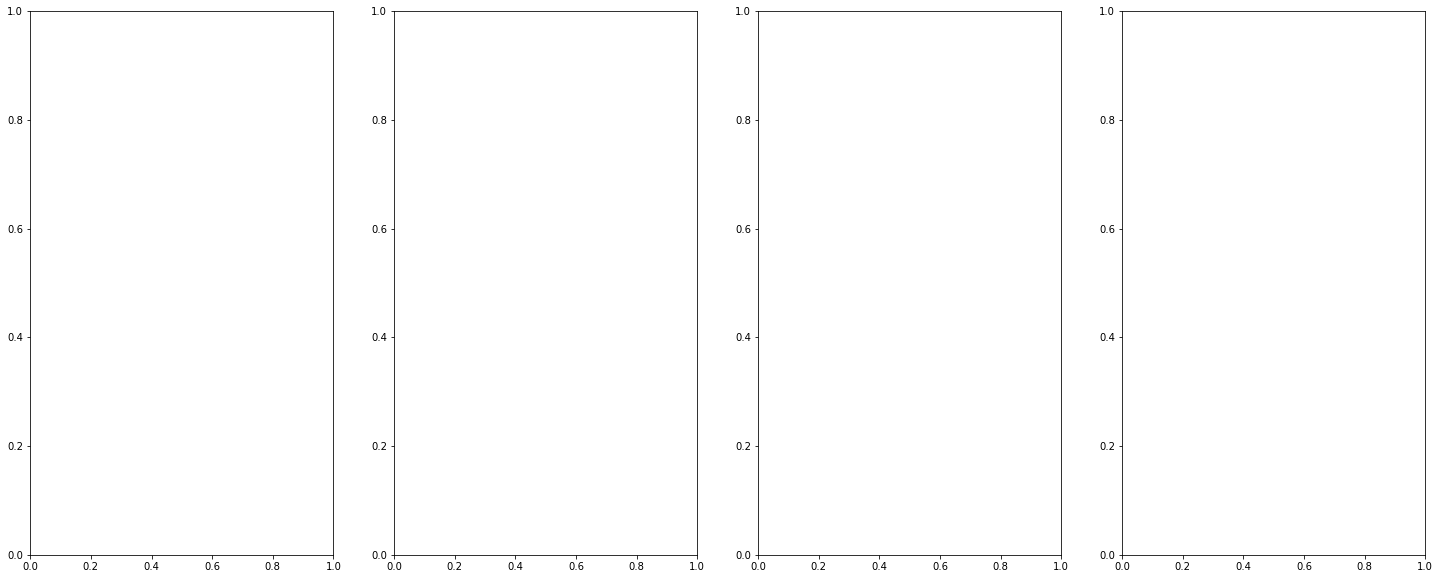

In [17]:
### 2D histogram ###

plt2, ax2 = mp.subplots(1,4,figsize=(25, 10)) # Ave plot of all cases

colors = ['black','skyblue','olive','coral']

for ic,case in enumerate(cases):

    fplot,vlong = pdf_data_proc(case,fdir0,vname,vscale) # Main variable
    fplotc,vlongc = pdf_data_proc(case,fdir0,vnamec,vscalec) # Always grab CONVECTIVE VARIABLE.
   
    

    ax2[ic].scatter(fplotc, fplot,color=colors[ic],alpha=0.1,marker='.',s=1)
    
#    ax2[ic].hist2d(fplotc, fplot, bins=(50, 50),range=([-50,10],[-20,50]))
    
    ax2[ic].vlines(0.,-60, 80, color='black',linestyle="dashed",lw=1)
    ax2[ic].hlines(0.,-60, 10, color='black',linestyle="dashed",lw=1)
    
    ax2[ic].set_title(cnames[ic],fontsize=24)
    ax2[ic].set_ylabel(vlong,fontsize=20) 
    ax2[ic].set_xlabel(vlongc,fontsize=15)
    ax2[ic].tick_params(axis='x', labelsize=16)
    ax2[ic].tick_params(axis='y', labelsize=16)
    
plt2.savefig('pdf_vres_scatter.png', dpi=100, bbox_inches='tight') 